In [1]:
library(Rsubread)
library(repr)
library(ggplot2)
library(ggrepel)
require(dplyr)
library(tidyr) 
library(reshape2)
library("DESeq2")
library(RColorBrewer)
library( "gplots" )
require('biomaRt')
require('pheatmap')
require(GenomicFeatures)
require('plotly')
require(TxDb.Dmelanogaster.UCSC.dm6.ensGene)
require('edgeR')
library("ggpubr")
library('htmlwidgets')

Warning message:
“package ‘ggrepel’ was built under R version 4.2.3”
Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    ma

In [2]:
#import ENSEMBL database
listEnsembl()
mart <- useMart(biomart = "ensembl", 
                dataset = "dmelanogaster_gene_ensembl", 
                host = "https://www.ensembl.org")
mart <- useDataset(dataset="dmelanogaster_gene_ensembl", mart=mart)

biomart,version
<chr>,<chr>
genes,Ensembl Genes 110
mouse_strains,Mouse strains 110
snps,Ensembl Variation 110
regulation,Ensembl Regulation 110


# 1- FeatureCounts

In [3]:
annotation_file="../../../../genome/Drosophila_melanogaster.BDGP6.32.107.gtf"
fasta_file="../../../../genome/Drosophila_melanogaster.BDGP6.32.dna_sm.toplevel.fa"


# FOR WT SAMPLES :
# counts.matrix.g080 <-featureCounts(
#               files = c('FBE14.bam','FBE15.bam','FBE16.bam','FBE17.bam','FBE18.bam','FBE19.bam'), 
#               GTF.attrType = "gene_id",
#               annot.ext = annotation_file,
#               genome= fasta_file,
#               isGTFAnnotationFile = TRUE,
#               useMetaFeatures=TRUE,
#               GTF.featureType= "gene",
#               nthreads = 40,
#               isPairedEnd = TRUE,
#               requireBothEndsMapped = TRUE,
#               countChimericFragments = FALSE,
#               juncCounts = TRUE)



# FOR DPLD SAMPLES :
# counts.matrix.dpld <-featureCounts(
#               files = c('FBE21.bam','FBE22.bam','FBE23.bam','FBE24.bam','FBE25.bam','FBE26.bam'), 
#               GTF.attrType = "gene_id",
#               annot.ext = annotation_file,
#               genome= fasta_file,
#               isGTFAnnotationFile = TRUE,
#               useMetaFeatures=TRUE,
#               GTF.featureType= "gene",
#               nthreads = 40,
#               isPairedEnd = TRUE,
#               requireBothEndsMapped = TRUE,
#               countChimericFragments = FALSE,
#               juncCounts = TRUE)

In [4]:
#import previously saved matrix
counts.matrix.g080 = readRDS("../../Analysis/synaptosome-july-2022/4.feature-counts/noCnoB/counts_G080_flybase.rds")

In [5]:
#import previously saved matrix
counts.matrix.dpld = readRDS("../../Analysis/synaptosome-july-2022/4.feature-counts/noCnoB/counts_dPLD_flybase.rds")

In [6]:
#convert the matrix to data frame
count.g080=as.data.frame(counts.matrix.g080$counts)
count.dpld=as.data.frame(counts.matrix.dpld$counts)

## 2- Data preparation

## -- WT --

In [7]:
print("original dimension")
dim(count.g080)

#here we remove all the Fbti
keep=NULL
keep <- count.g080[!grepl("FBti", row.names(count.g080)),] 
genesTokeep=which(rownames(count.g080) %in% row.names(keep))
count.g080 <- count.g080[genesTokeep, ]
print("after removing genes with FBti")
dim(count.g080)

#here we remove all the transposable element (they start with RR)
keep=NULL
keep <- count.g080[!grepl("RR", row.names(count.g080)),] 
genesTokeep=which(rownames(count.g080) %in% row.names(keep))
count.g080 <- count.g080[genesTokeep, ]
print("after removing genes with RR")
dim(count.g080)

#here we remove genes with 0 reads in all samples
keep_genes <- rowSums(count.g080) > 0 #TRUE if the gene has more that 0 reads, if not : FALSE
count.g080 <- count.g080[ keep_genes, ]
print("after removing genes with 0 reads")
dim(count.g080) #I removed the 2000 genes with 0 reads

#cpm filtering
keep <- rowSums(cpm(count.g080) > 0.5) >= 3
count.g080<- count.g080[keep , ]
print('after removing genes with cpm')
dim(count.g080)

[1] "original dimension"


[1] 23932     6

[1] "after removing genes with FBti"


[1] 18516     6

[1] "after removing genes with RR"


[1] 18354     6

[1] "after removing genes with 0 reads"


[1] 15807     6

[1] "after removing genes with cpm"


[1] 10503     6

## -- DPLD --

In [8]:
print("original dimension")
dim(count.dpld)

#here we remove all the Fbti
keep=NULL
keep <- count.dpld[!grepl("FBti", row.names(count.dpld)),] 
genesTokeep=which(rownames(count.dpld) %in% row.names(keep))
count.dpld <- count.dpld[genesTokeep, ]
print("after removing genes with FBti")
dim(count.dpld)

#here we remove all the transposable element (they start with RR)
keep=NULL
keep <- count.dpld[!grepl("RR", row.names(count.dpld)),] 
genesTokeep=which(rownames(count.dpld) %in% row.names(keep))
count.dpld <- count.dpld[genesTokeep, ]
print("after removing genes with RR")
dim(count.dpld)

#here we remove genes with 0 reads in all samples
keep_genes <- rowSums(count.dpld) > 0 #TRUE if the gene has more that 0 reads, if not : FALSE
count.dpld <- count.dpld[ keep_genes, ]
print("after removing genes with 0 reads")
dim(count.dpld) #I removed the 2000 genes with 0 reads

#cpm filtering
keep <- rowSums(cpm(count.dpld) > 0.5) >= 3
count.dpld<- count.dpld[keep , ]
print('after removing genes with cpm')
dim(count.dpld)

[1] "original dimension"


[1] 23932     6

[1] "after removing genes with FBti"


[1] 18516     6

[1] "after removing genes with RR"


[1] 18354     6

[1] "after removing genes with 0 reads"


[1] 16759     6

[1] "after removing genes with cpm"


[1] 11910     6

# 3- Build DESeq2 matrix

The files are organized as follows:
FBE14 : original input
FBE15 : fraction from FBE14 enriched in synaptosomes
FBE16 : original input
FBE17 : fraction from FBE16 enriched in synaptosomes
...
so there is 2 relationships between samples to consider :
- condition : input or synaptosomes enriched
- sample.ID : (FBE14+FBE15), (FBE16+FB17), ...

In [9]:
#setting up sample info:
sample_info <- DataFrame(condition = c("input","synap", "input", "synap", "input", "synap"),sample.ID=c("1","1","2","2","3","3"), row.names = names(count) )
sample_info$condition=as.factor(sample_info$condition)
sample_info$sample.ID=as.factor(sample_info$sample.ID)

## -- WT --

In [10]:
#intializing dds object:
dds.g080 <- DESeqDataSetFromMatrix(countData = count.g080,colData = sample_info,design = ~ condition + sample.ID)


## -- DPLD --

In [11]:
#intializing dds object:
dds.dpld <- DESeqDataSetFromMatrix(countData = count.dpld,colData = sample_info,design = ~ condition + sample.ID)


### plot 1 : number of reads per sample

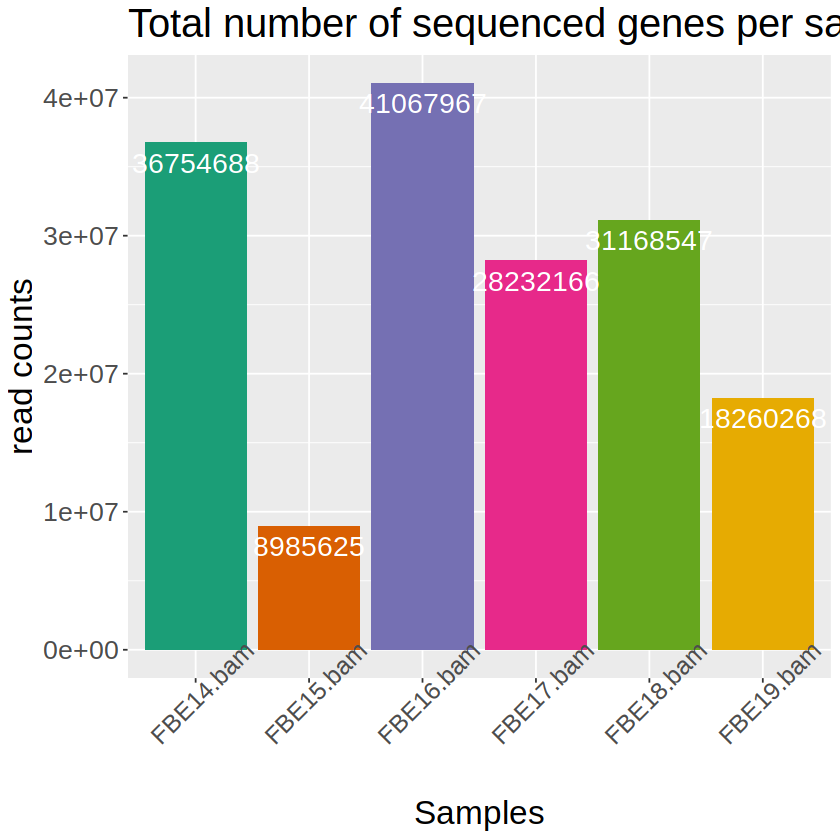

In [12]:
g=melt(colSums(counts(dds.g080)))
readCounts_plot<-ggplot(data=g, aes(x=rownames(g), y=value, fill=rownames(g))) +
  geom_bar(stat="identity") +
  #scale_fill_manual(values = mycolors)
    scale_fill_brewer(palette="Dark2") + theme(legend.position = "none") +
  geom_text(aes(label=value), vjust=1.6, color="white", size=6) +
  ggtitle("Total number of sequenced genes per sample")+ theme(text = element_text(size=20), axis.text.x = element_text(size=15, angle = 45))+
  xlab("Samples") + ylab("read counts")
readCounts_plot

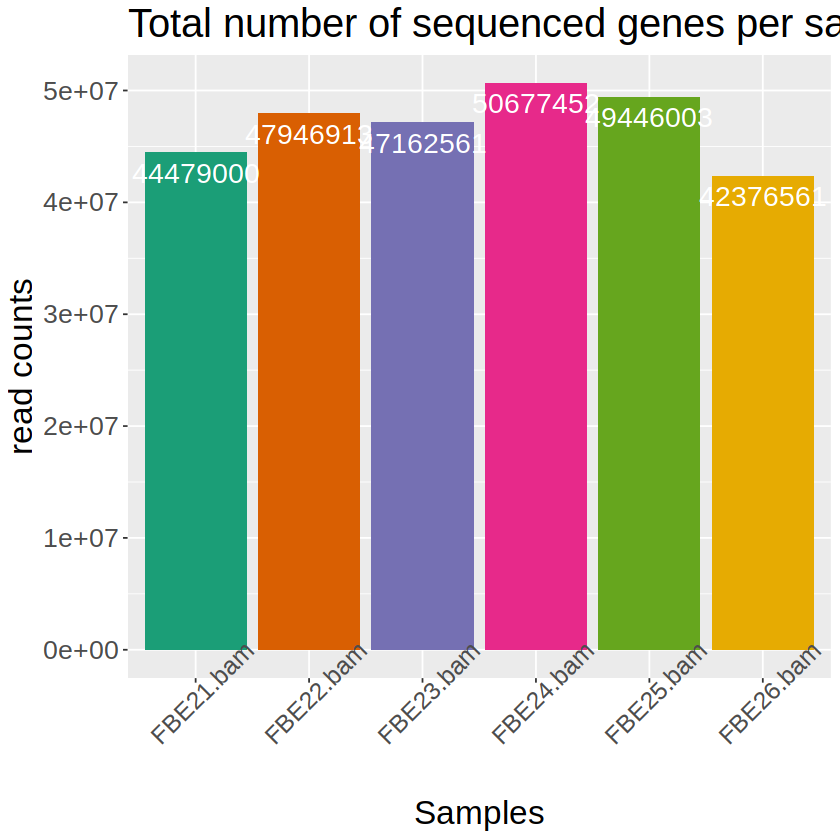

In [13]:
g=melt(colSums(counts(dds.dpld)))
readCounts_plot<-ggplot(data=g, aes(x=rownames(g), y=value, fill=rownames(g))) +
  geom_bar(stat="identity") +
  #scale_fill_manual(values = mycolors)
    scale_fill_brewer(palette="Dark2") + theme(legend.position = "none") +
  geom_text(aes(label=value), vjust=1.6, color="white", size=6) +
  ggtitle("Total number of sequenced genes per sample")+ theme(text = element_text(size=20), axis.text.x = element_text(size=15, angle = 45))+
  xlab("Samples") + ylab("read counts")
readCounts_plot

# 4- Normalization by DESeq2

## -- WT --

In [14]:
dds.g080 <- estimateSizeFactors(dds.g080)
sizeFactors(dds.g080)
normalized_counts_byDeseq2_g080 <- counts(dds.g080, normalized=TRUE)
head(normalized_counts_byDeseq2_g080)

# prepare files to save them later : by adding gene names
normalized_counts_byDeseq2_g080=as.data.frame(normalized_counts_byDeseq2_g080)
mapping_geneName =  getBM(attributes=c("ensembl_gene_id","external_gene_name"), mart=mart, values=normalized_counts_byDeseq2_g080, uniqueRows=TRUE, bmHeader = T)
normalized_counts_byDeseq2_g080$genes=row.names(normalized_counts_byDeseq2_g080)
normalized_counts_byDeseq2_g080 = merge(normalized_counts_byDeseq2_g080, mapping_geneName, by.x='genes', by.y="Gene stable ID", all.x=TRUE, all.y=FALSE)


FBE14.bam FBE15.bam FBE16.bam FBE17.bam FBE18.bam FBE19.bam 
1.8642706 0.3825190 1.8108325 0.9145406 1.3511545 0.6252210

,FBE14.bam,FBE15.bam,FBE16.bam,FBE17.bam,FBE18.bam,FBE19.bam
FBgn0250732,681.7680,5.751349e+02,715.1407,6.527868e+02,702.36233,6.941545e+02
FBgn0037409,148.0472,1.751547e+02,153.5205,8.200839e+01,129.51887,7.517342e+01
FBgn0027948,6528.5585,5.097786e+03,6651.6367,7.849843e+03,6684.65395,7.306216e+03
FBgn0038675,158.7752,9.149873e+01,106.0286,1.224659e+02,98.43434,1.263553e+02
FBgn0000500,183.4498,2.561964e+02,195.4902,2.274366e+02,166.52426,1.775372e+02
FBgn0261504,430986.7789,2.379456e+06,883898.9700,5.154853e+06,915707.29853,4.029612e+06


## -- DPLD --

In [15]:
dds.dpld <- estimateSizeFactors(dds.dpld)
sizeFactors(dds.dpld)
normalized_counts_byDeseq2_dpld <- counts(dds.dpld, normalized=TRUE)
head(normalized_counts_byDeseq2_dpld)

# prepare files to save them later : by adding gene names
normalized_counts_byDeseq2_dpld=as.data.frame(normalized_counts_byDeseq2_dpld)
mapping_geneName =  getBM(attributes=c("ensembl_gene_id","external_gene_name"), mart=mart, values=normalized_counts_byDeseq2_dpld, uniqueRows=TRUE, bmHeader = T)
normalized_counts_byDeseq2_dpld$genes=row.names(normalized_counts_byDeseq2_dpld)
normalized_counts_byDeseq2_dpld = merge(normalized_counts_byDeseq2_dpld, mapping_geneName, by.x='genes', by.y="Gene stable ID", all.x=TRUE, all.y=FALSE)

FBE21.bam FBE22.bam FBE23.bam FBE24.bam FBE25.bam FBE26.bam 
1.1774420 0.8715859 1.1811355 0.8582961 1.2828411 0.7801253

,FBE21.bam,FBE22.bam,FBE23.bam,FBE24.bam,FBE25.bam,FBE26.bam
FBgn0250732,1288.3862,1281.5719,1615.3947,1484.3362,1347.7897,1375.4201
FBgn0037409,162.2161,168.6581,133.7696,165.4441,127.0617,129.4664
FBgn0027948,12690.2215,11897.8515,13653.8106,13266.9834,12024.8723,13875.9768
FBgn0038675,236.9543,270.7708,278.5455,322.7324,211.2499,264.0602
FBgn0000500,221.6670,588.5822,345.4303,454.3886,258.0211,334.5617
FBgn0261504,1474430.1456,8277715.0507,1611556.0389,8766918.6417,1433101.9277,7814548.8906


# 5- Transformation and quality control

## -- WT --

,FBE14.bam,FBE15.bam,FBE16.bam,FBE17.bam,FBE18.bam,FBE19.bam
FBgn0250732,9.401853,9.263780,9.442186,9.365592,9.426860,9.416720
FBgn0037409,7.068747,7.171833,7.093471,6.710589,6.979486,6.672012
FBgn0027948,12.681725,12.465703,12.698420,12.848372,12.702852,12.782922


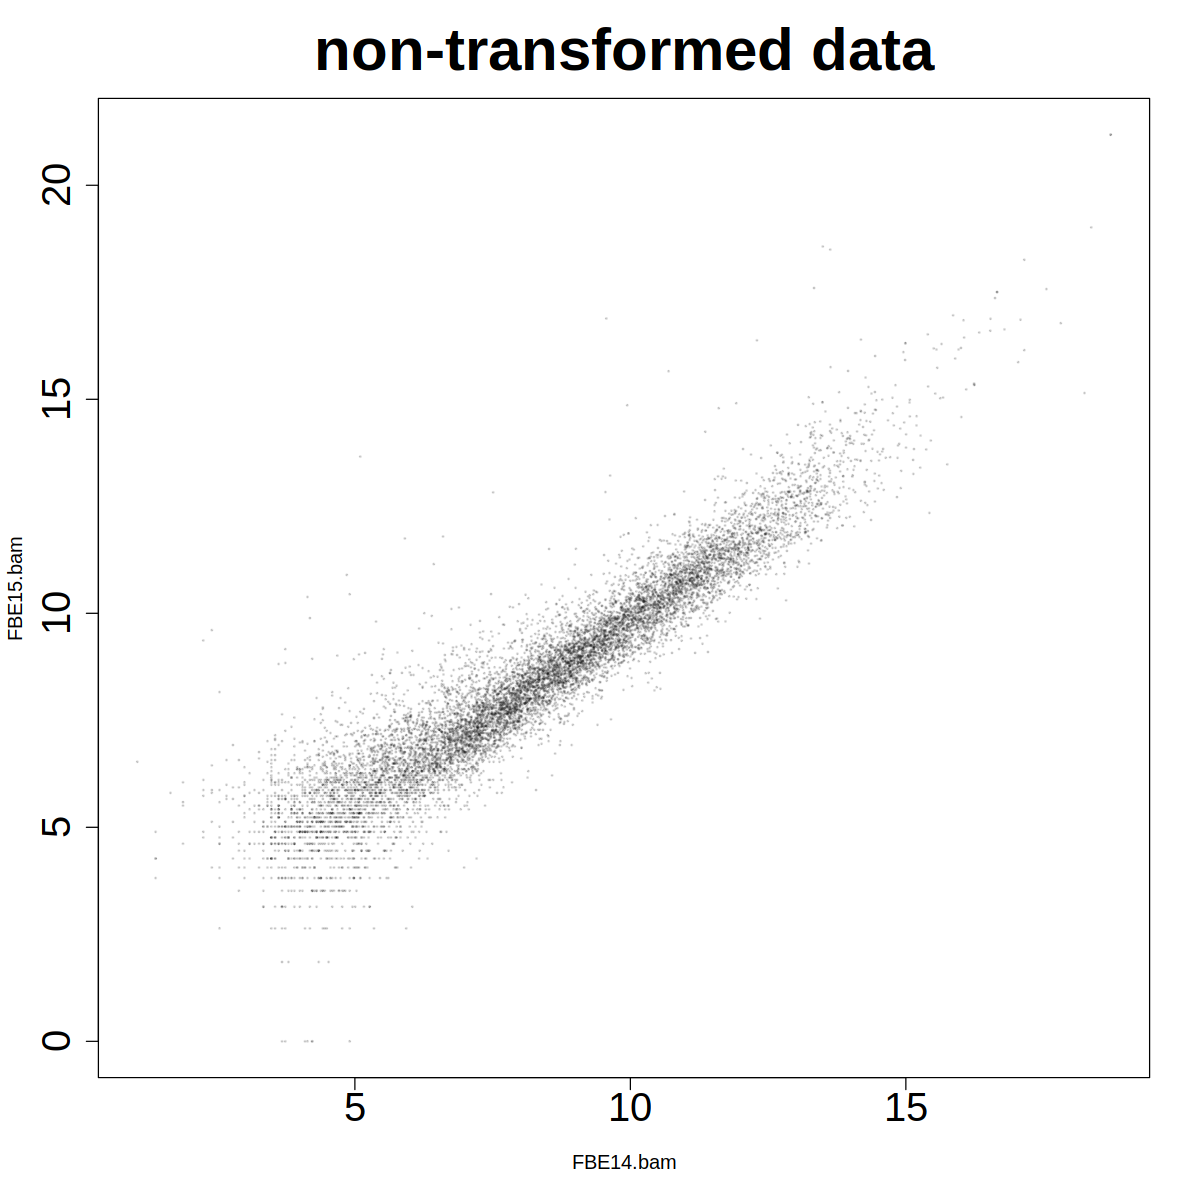

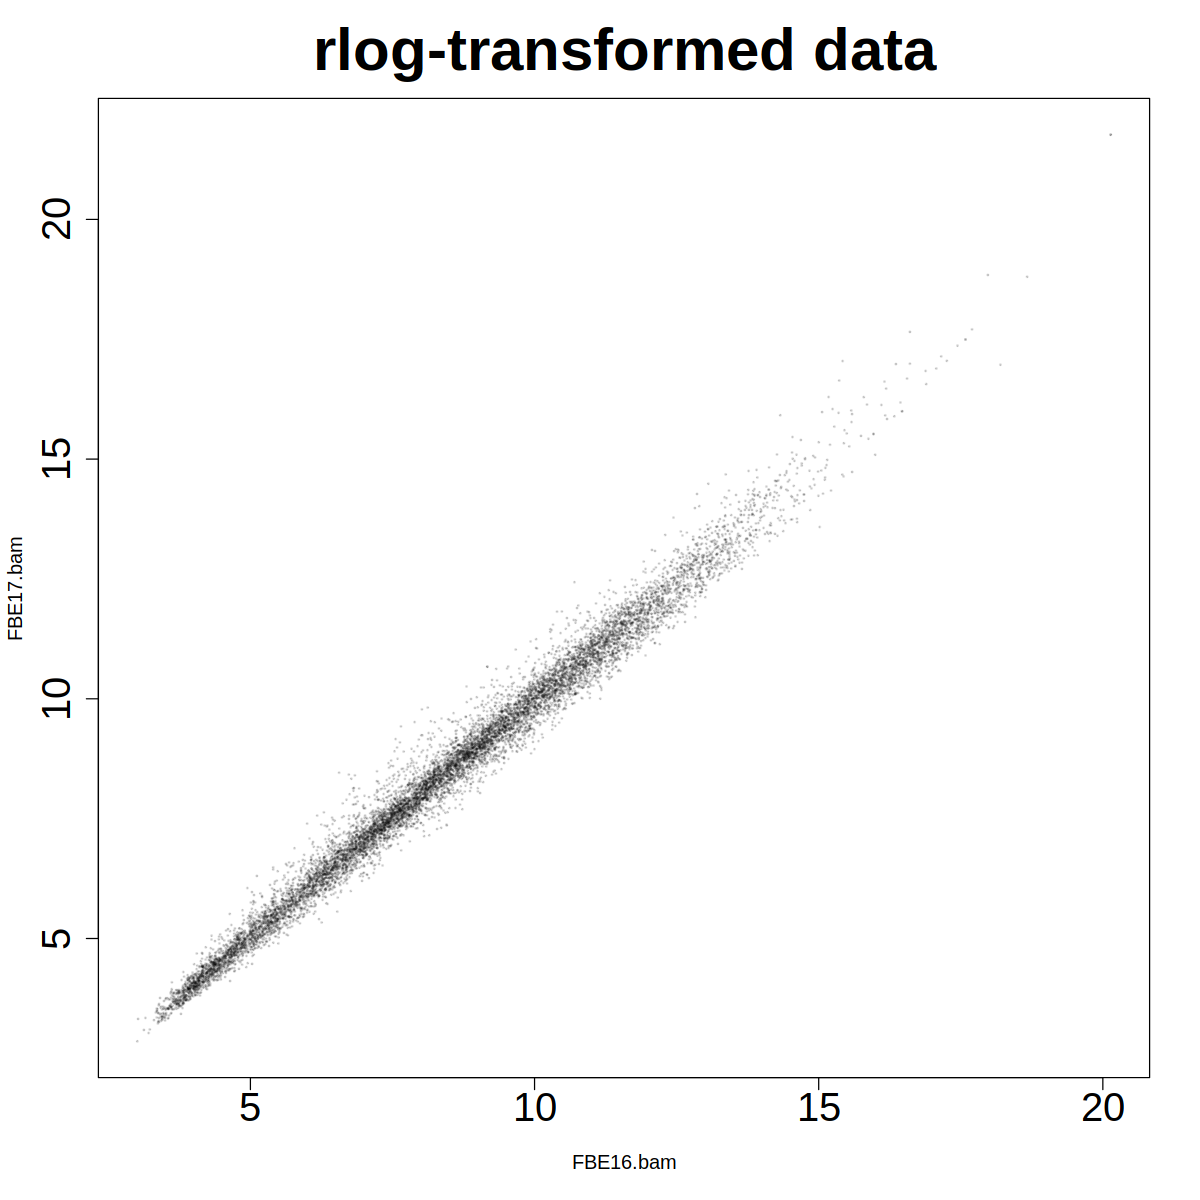

In [16]:
#rlog transformation
rld.g080 <- rlog( dds.g080 )
assay(rld.g080)[ 1:3,]

options(repr.plot.width=10, repr.plot.height=10)


#plot : before transformation (just a simple log to help visualization
plot( log2( 1+counts(dds.g080, normalized=TRUE)[, 1:2] ), col="#00000020", pch=20, cex=0.3, main="non-transformed data", cex.main=3, cex.axis=2 )
#plot : after transformation 
plot( assay(rld.g080)[, 3:4], col="#00000020", pch=20, cex=0.3, main="rlog-transformed data", cex.main=3, cex.axis=2)


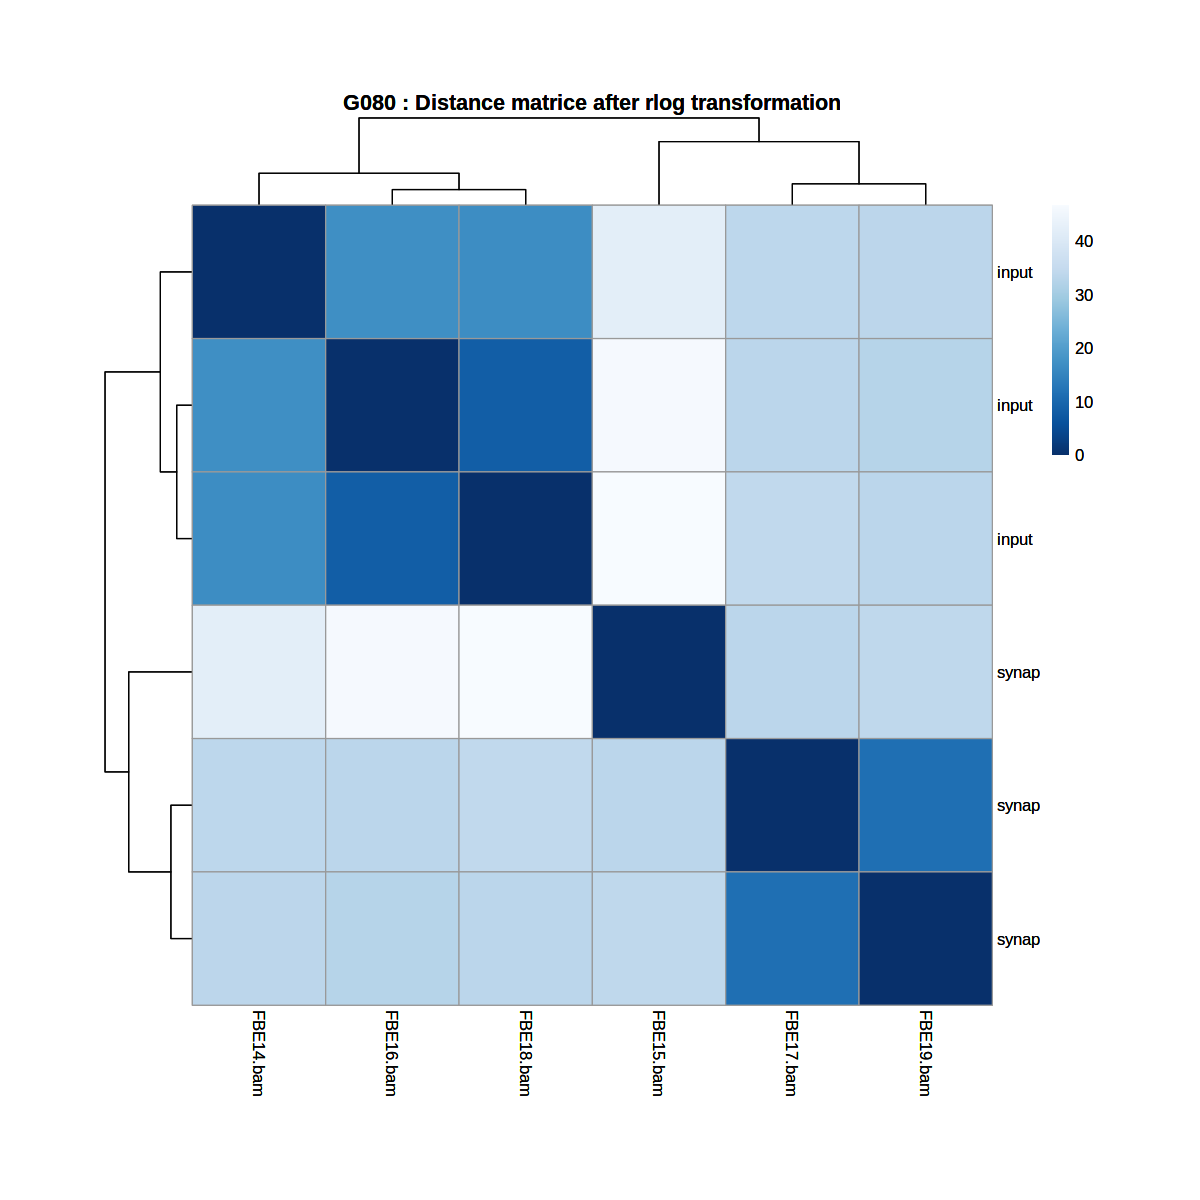

In [17]:

# Distance matrice : assess overall similarity between samples
sampleDists_rld.g080 <- dist(t(assay(rld.g080)))
sampleDistMatrix_rld.g080 <- as.matrix( sampleDists_rld.g080 )
rownames(sampleDistMatrix_rld.g080) <- dds.g080$condition
colnames(sampleDistMatrix_rld.g080) <- colnames(rld.g080)  
colours = colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap_distMatrice.g080=pheatmap(sampleDistMatrix_rld.g080,
         clustering_distance_rows=sampleDists_rld.g080,
         clustering_distance_cols=sampleDists_rld.g080,
         col=colours, main="G080 : Distance matrice after rlog transformation",     
cellheight=80, cellwidth = 80)

pheatmap_distMatrice.g080

## -- DPLD --

,FBE21.bam,FBE22.bam,FBE23.bam,FBE24.bam,FBE25.bam,FBE26.bam
FBgn0250732,10.378062,10.373659,10.573419,10.499560,10.41642,10.433833
FBgn0037409,7.263234,7.288159,7.141096,7.275552,7.10976,7.122179
FBgn0027948,13.639690,13.582497,13.705314,13.679466,13.59186,13.719853


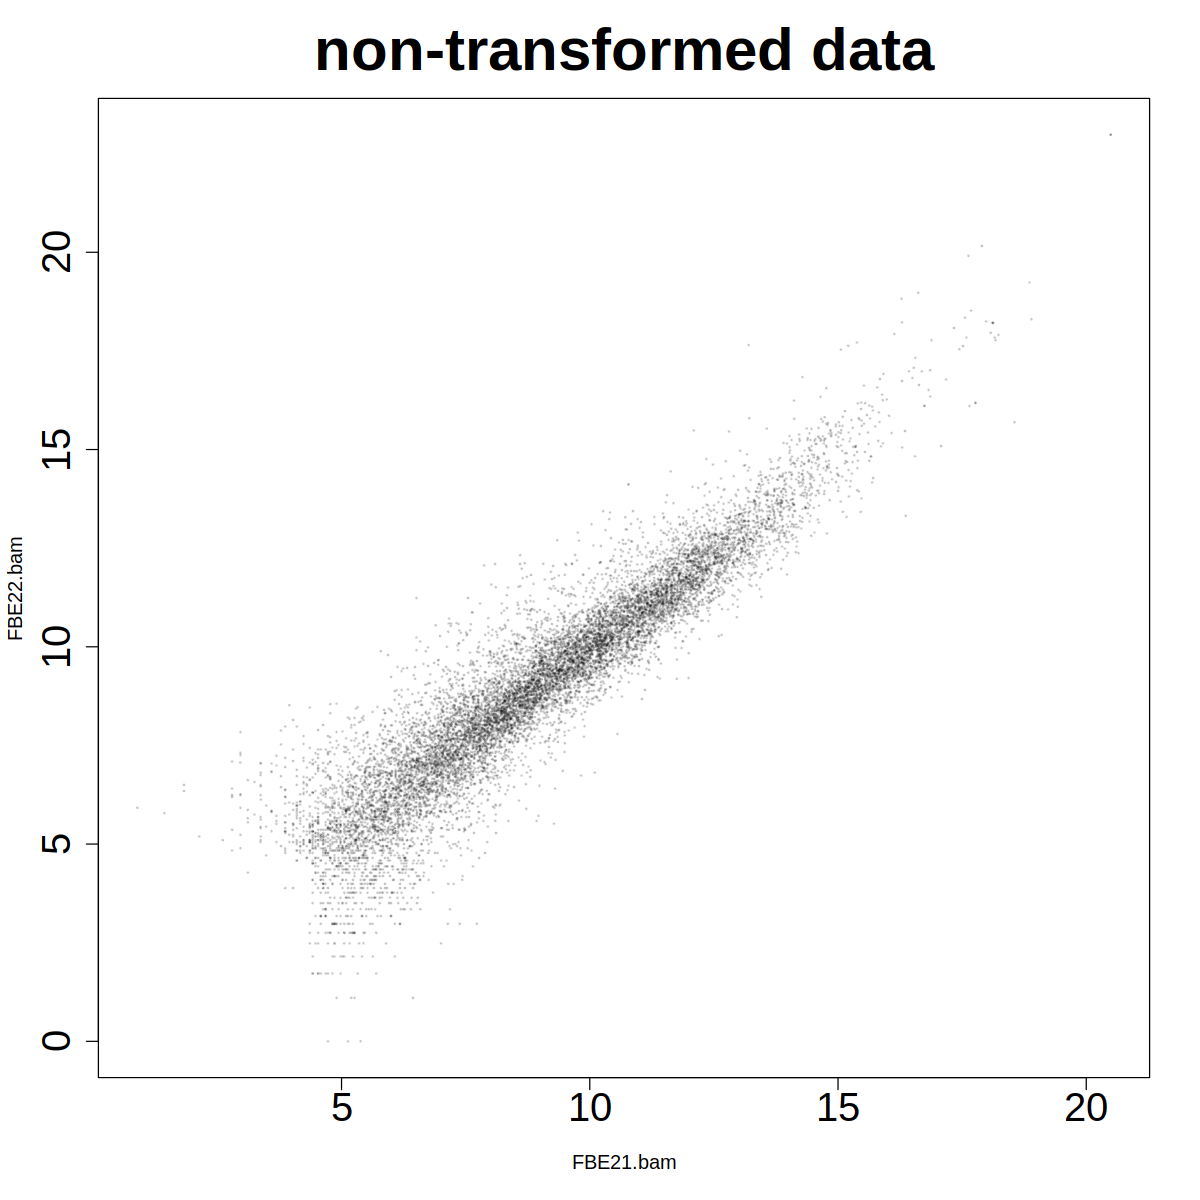

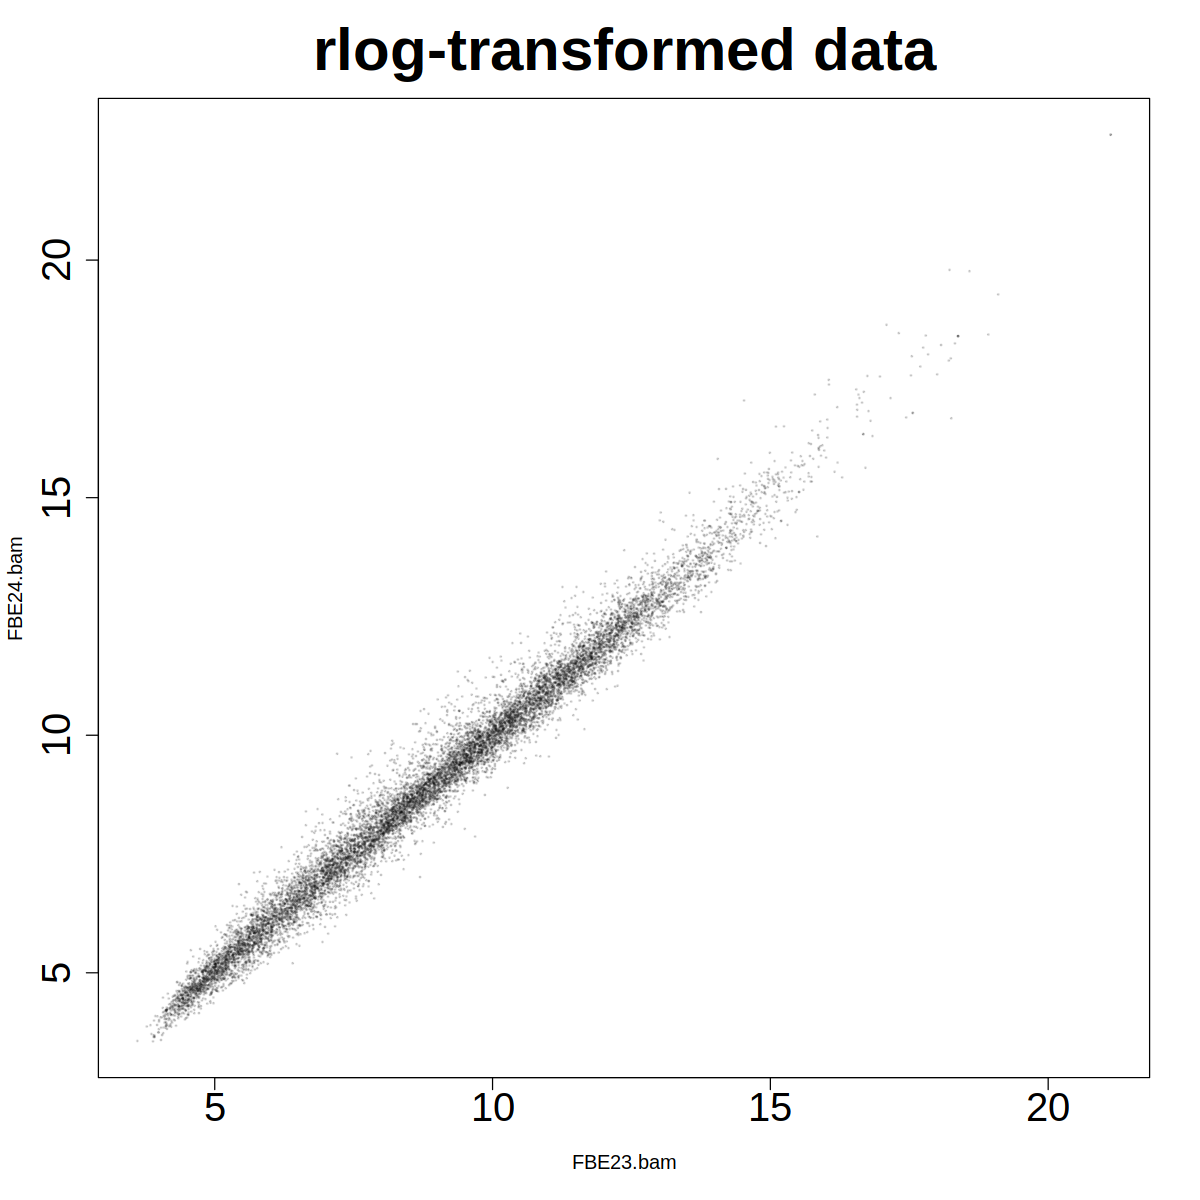

In [18]:
#rlog transformation
rld.dpld <- rlog( dds.dpld )
assay(rld.dpld)[ 1:3,]

options(repr.plot.width=10, repr.plot.height=10)


#plot : before transformation (just a simple log to help visualization
plot( log2( 1+counts(dds.dpld, normalized=TRUE)[, 1:2] ), col="#00000020", pch=20, cex=0.3, main="non-transformed data", cex.main=3, cex.axis=2 )
#plot : after transformation 
plot( assay(rld.dpld)[, 3:4], col="#00000020", pch=20, cex=0.3, main="rlog-transformed data", cex.main=3, cex.axis=2)


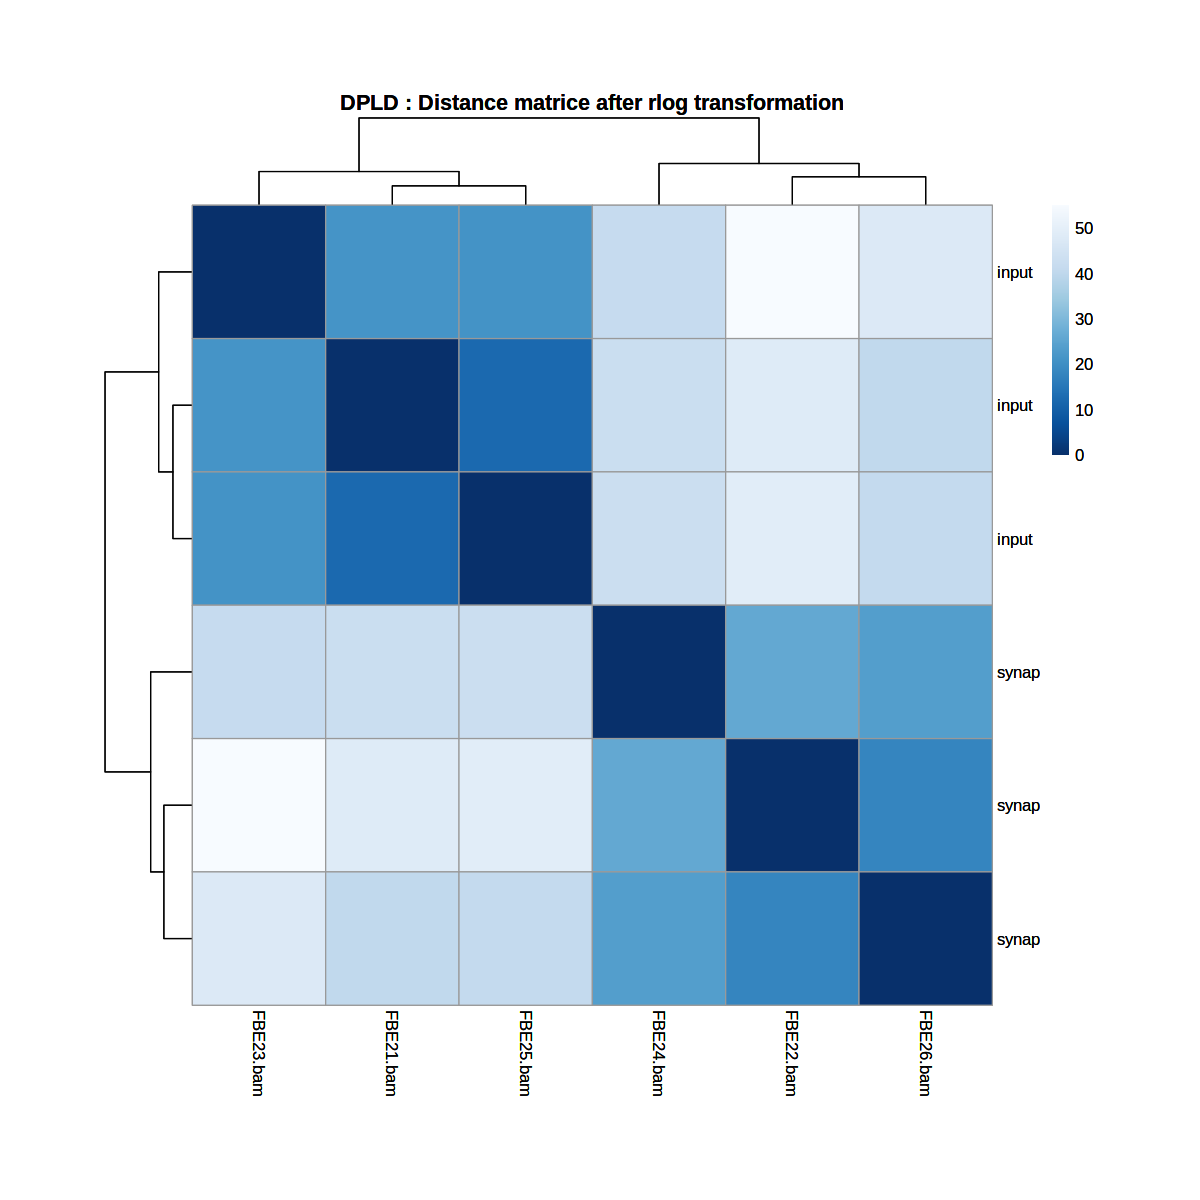

In [19]:

# Distance matrice : assess overall similarity between samples
sampleDists_rld.dpld <- dist(t(assay(rld.dpld)))
sampleDistMatrix_rld.dpld <- as.matrix( sampleDists_rld.dpld )
rownames(sampleDistMatrix_rld.dpld) <- dds.dpld$condition
colnames(sampleDistMatrix_rld.dpld) <- colnames(rld.dpld)  
colours = colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap_distMatrice.dpld=pheatmap(sampleDistMatrix_rld.dpld,
         clustering_distance_rows=sampleDists_rld.dpld,
         clustering_distance_cols=sampleDists_rld.dpld,
         col=colours, main="DPLD : Distance matrice after rlog transformation",     
cellheight=80, cellwidth = 80)

pheatmap_distMatrice.dpld

# 6- Running DESeq2

## -- WT --

In [20]:
dds.g080 <- DESeq(dds.g080)
res.g080 <- results(dds.g080, alpha=0.05, contrast=c("condition", "synap","input"), pAdjustMethod="BH")
res.g080
summary(res.g080)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition synap vs input 
Wald test p-value: condition synap vs input 
DataFrame with 10503 rows and 6 columns
              baseMean log2FoldChange     lfcSE       stat      pvalue
             <numeric>      <numeric> <numeric>  <numeric>   <numeric>
FBgn0250732    670.225    -0.12897628  0.144572 -0.8921273    0.372325
FBgn0037409    127.237    -0.48171505  0.322184 -1.4951564    0.134874
FBgn0027948   6686.449     0.00527131  0.138972  0.0379306    0.969743
FBgn0038675    117.260    -0.05411625  0.323874 -0.1670905    0.867299
FBgn0000500    201.106     0.26306361  0.222036  1.1847797    0.236105
...                ...            ...       ...        ...         ...
FBgn0267511 63477.7145       2.928160 0.6395877   4.578199 4.68995e-06
FBgn0085753 92666.0105       1.748063 1.1766839   1.485584 1.37389e-01
FBgn0267507 74374.1665      -0.790561 0.0955329  -8.275272 1.28162e-16
FBgn0259849    13.4052      -0.687203 0.7750208  -0.886689 3.75246e-01
FBgn0085494  


out of 10503 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1827, 17%
LFC < 0 (down)     : 1943, 18%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [21]:
#converting to dataframe
results.g080 = as.data.frame(res.g080)

## -- DPLD --

In [22]:
dds.dpld <- DESeq(dds.dpld)
res.dpld <- results(dds.dpld, alpha=0.05, contrast=c("condition", "synap","input"), pAdjustMethod="BH")
res.dpld
summary(res.dpld)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



log2 fold change (MLE): condition synap vs input 
Wald test p-value: condition synap vs input 
DataFrame with 11910 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
FBgn0250732    1398.816     -0.0338736 0.1056384 -0.320656 0.748471172
FBgn0037409     147.769      0.1306603 0.2230820  0.585705 0.558073625
FBgn0027948   12901.619      0.0239818 0.0924625  0.259368 0.795351364
FBgn0038675     264.052      0.2415572 0.1737356  1.390373 0.164415690
FBgn0000500     367.108      0.7248390 0.2010925  3.604506 0.000312747
...                 ...            ...       ...       ...         ...
FBgn0267506 150987.4384      -1.377357 0.0904836 -15.22217 2.52043e-52
FBgn0267511  35250.3675       1.521822 0.0896655  16.97221 1.31882e-64
FBgn0085753 133640.0686       1.409632 0.1138049  12.38639 3.09676e-35
FBgn0267507 163144.6047      -1.423356 0.0907231 -15.68903 1.79788e-55
FBgn0085494  


out of 11910 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3558, 30%
LFC < 0 (down)     : 3208, 27%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [23]:
#converting to dataframe
results.dpld = as.data.frame(res.dpld)

# 7- Data analysis

## -- WT --

### plot 2 : VolcanoPlot

In [24]:
#let's display and annotate genes that have significant LFC greater or equal to +0.85 / lower or equal to -0.85.
VolPlot.g080 = results.g080 %>% 
  mutate(
    Expression = case_when(log2FoldChange >= 0.85 & padj < 0.05 ~ "Up-regulated in synaptosome",
                           log2FoldChange <= -0.85 & padj < 0.05 ~ "Up-regulated in other fractions",
                           TRUE ~ "Unchanged")
    )


In [25]:
# adding ENSEMBL gene names to the table
mapping_geneNames <-  getBM(attributes=c("ensembl_gene_id","external_gene_name", "transcript_biotype"), mart=mart, values=VolPlot.g080, uniqueRows=TRUE, bmHeader = T)
VolPlot.g080 = merge(VolPlot.g080,mapping_geneNames, by.x='row.names', by.y='Gene stable ID', all.x=TRUE, all.y=FALSE)
rownames(VolPlot.g080)=VolPlot.g080$Row.names
VolPlot.g080$Row.names=NULL
head(VolPlot.g080)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Expression,Gene name,Transcript type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
FBgn0000003,2.299135e+06,2.3823611,0.9872131,2.4132186,0.0158123326,0.044925888,Up-regulated in synaptosome,7SLRNA:CR32864,ncRNA
FBgn0000008,1.301826e+03,-0.4296806,0.1178641,-3.6455590,0.0002668112,0.001196549,Unchanged,a,protein_coding
FBgn0000014,5.264860e+01,-0.3835894,1.4597389,-0.2627795,0.7927205657,0.876599716,Unchanged,abd-A,protein_coding
FBgn0000015,1.066994e+02,1.2853969,1.0907368,1.1784666,0.2386106313,0.394665742,Unchanged,Abd-B,protein_coding
FBgn0000017,6.159021e+03,-0.3451560,0.1114056,-3.0981917,0.0019470544,0.007272373,Unchanged,Abl,protein_coding
FBgn0000018,8.554153e+01,0.1599383,0.3096553,0.5165042,0.6055022952,0.746606082,Unchanged,abo,protein_coding


In [26]:
# genes with significant LFC >= 0.85 are enriched in fractions enriched in synaptosomes.
# genes with significalt LFC <= -0.85 are enriched in the input franctions
top <- 20
top_genes <- bind_rows(
  VolPlot.g080 %>% 
    filter(Expression == 'Up-regulated in synaptosome') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  VolPlot.g080 %>% 
    filter(Expression == 'Up-regulated in other fractions') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)

Warning message in geom_label_repel(data = top_genes, mapping = aes(log2FoldChange, :
“Ignoring unknown parameters: `face`”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


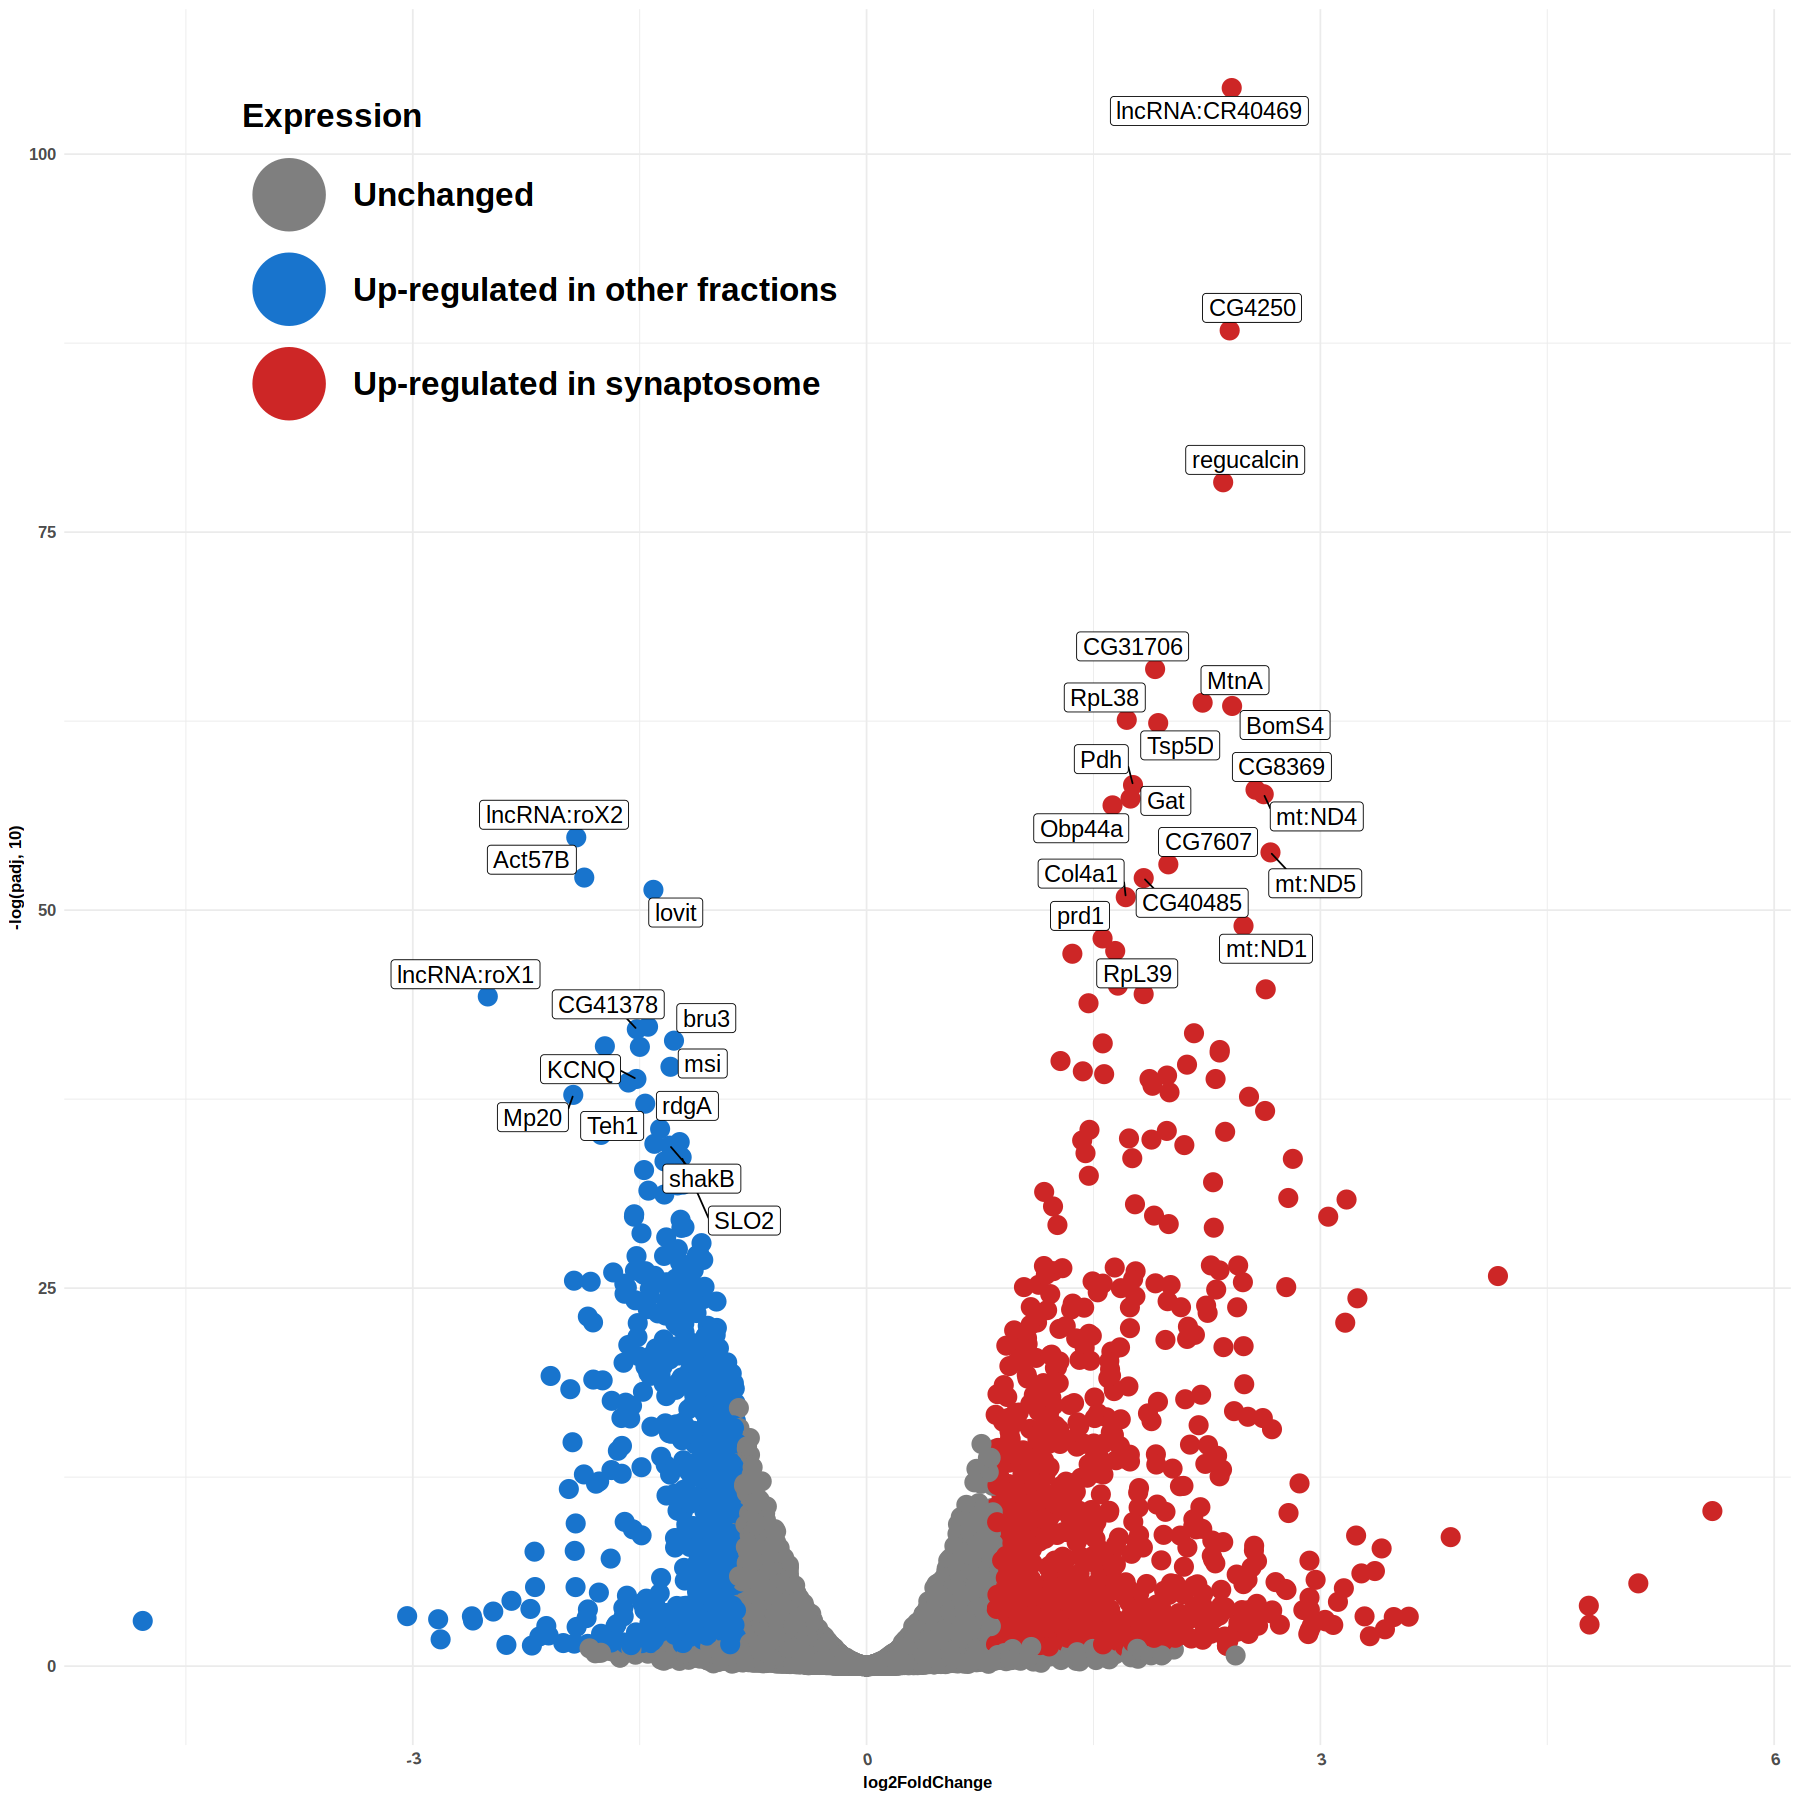

In [27]:
options(repr.plot.width=15, repr.plot.height=15)
VolcanoPlot.g080=ggplot(VolPlot.g080, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 5) +
  scale_color_manual(values = c("gray50","dodgerblue3",  "firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=20)))+
  geom_label_repel(data = top_genes,
                   mapping = aes(log2FoldChange, -log(padj,10), label = `Gene name`),
                   size = 5, face='bold')+
  theme_minimal()+
  theme(axis.text.x = element_text(angle=10, size = 10, face='bold'),
          axis.text.y = element_text(size = 10, face='bold'),
        axis.title = element_text(size =10, face='bold'),
         plot.title= element_text(hjust = 0.5, size = 20, face='bold'),
        legend.text = element_text(size = 20, face='bold'),
        legend.title = element_text(size = 20, face='bold'),
        legend.key.size = unit(3,"line"),
    legend.position = c(.1, .95),
    legend.justification = c("left", "top"),
    legend.box.just = "left",legend.margin = margin(3, 3, 3, 3))
VolcanoPlot.g080

### plot 3 : MAplot

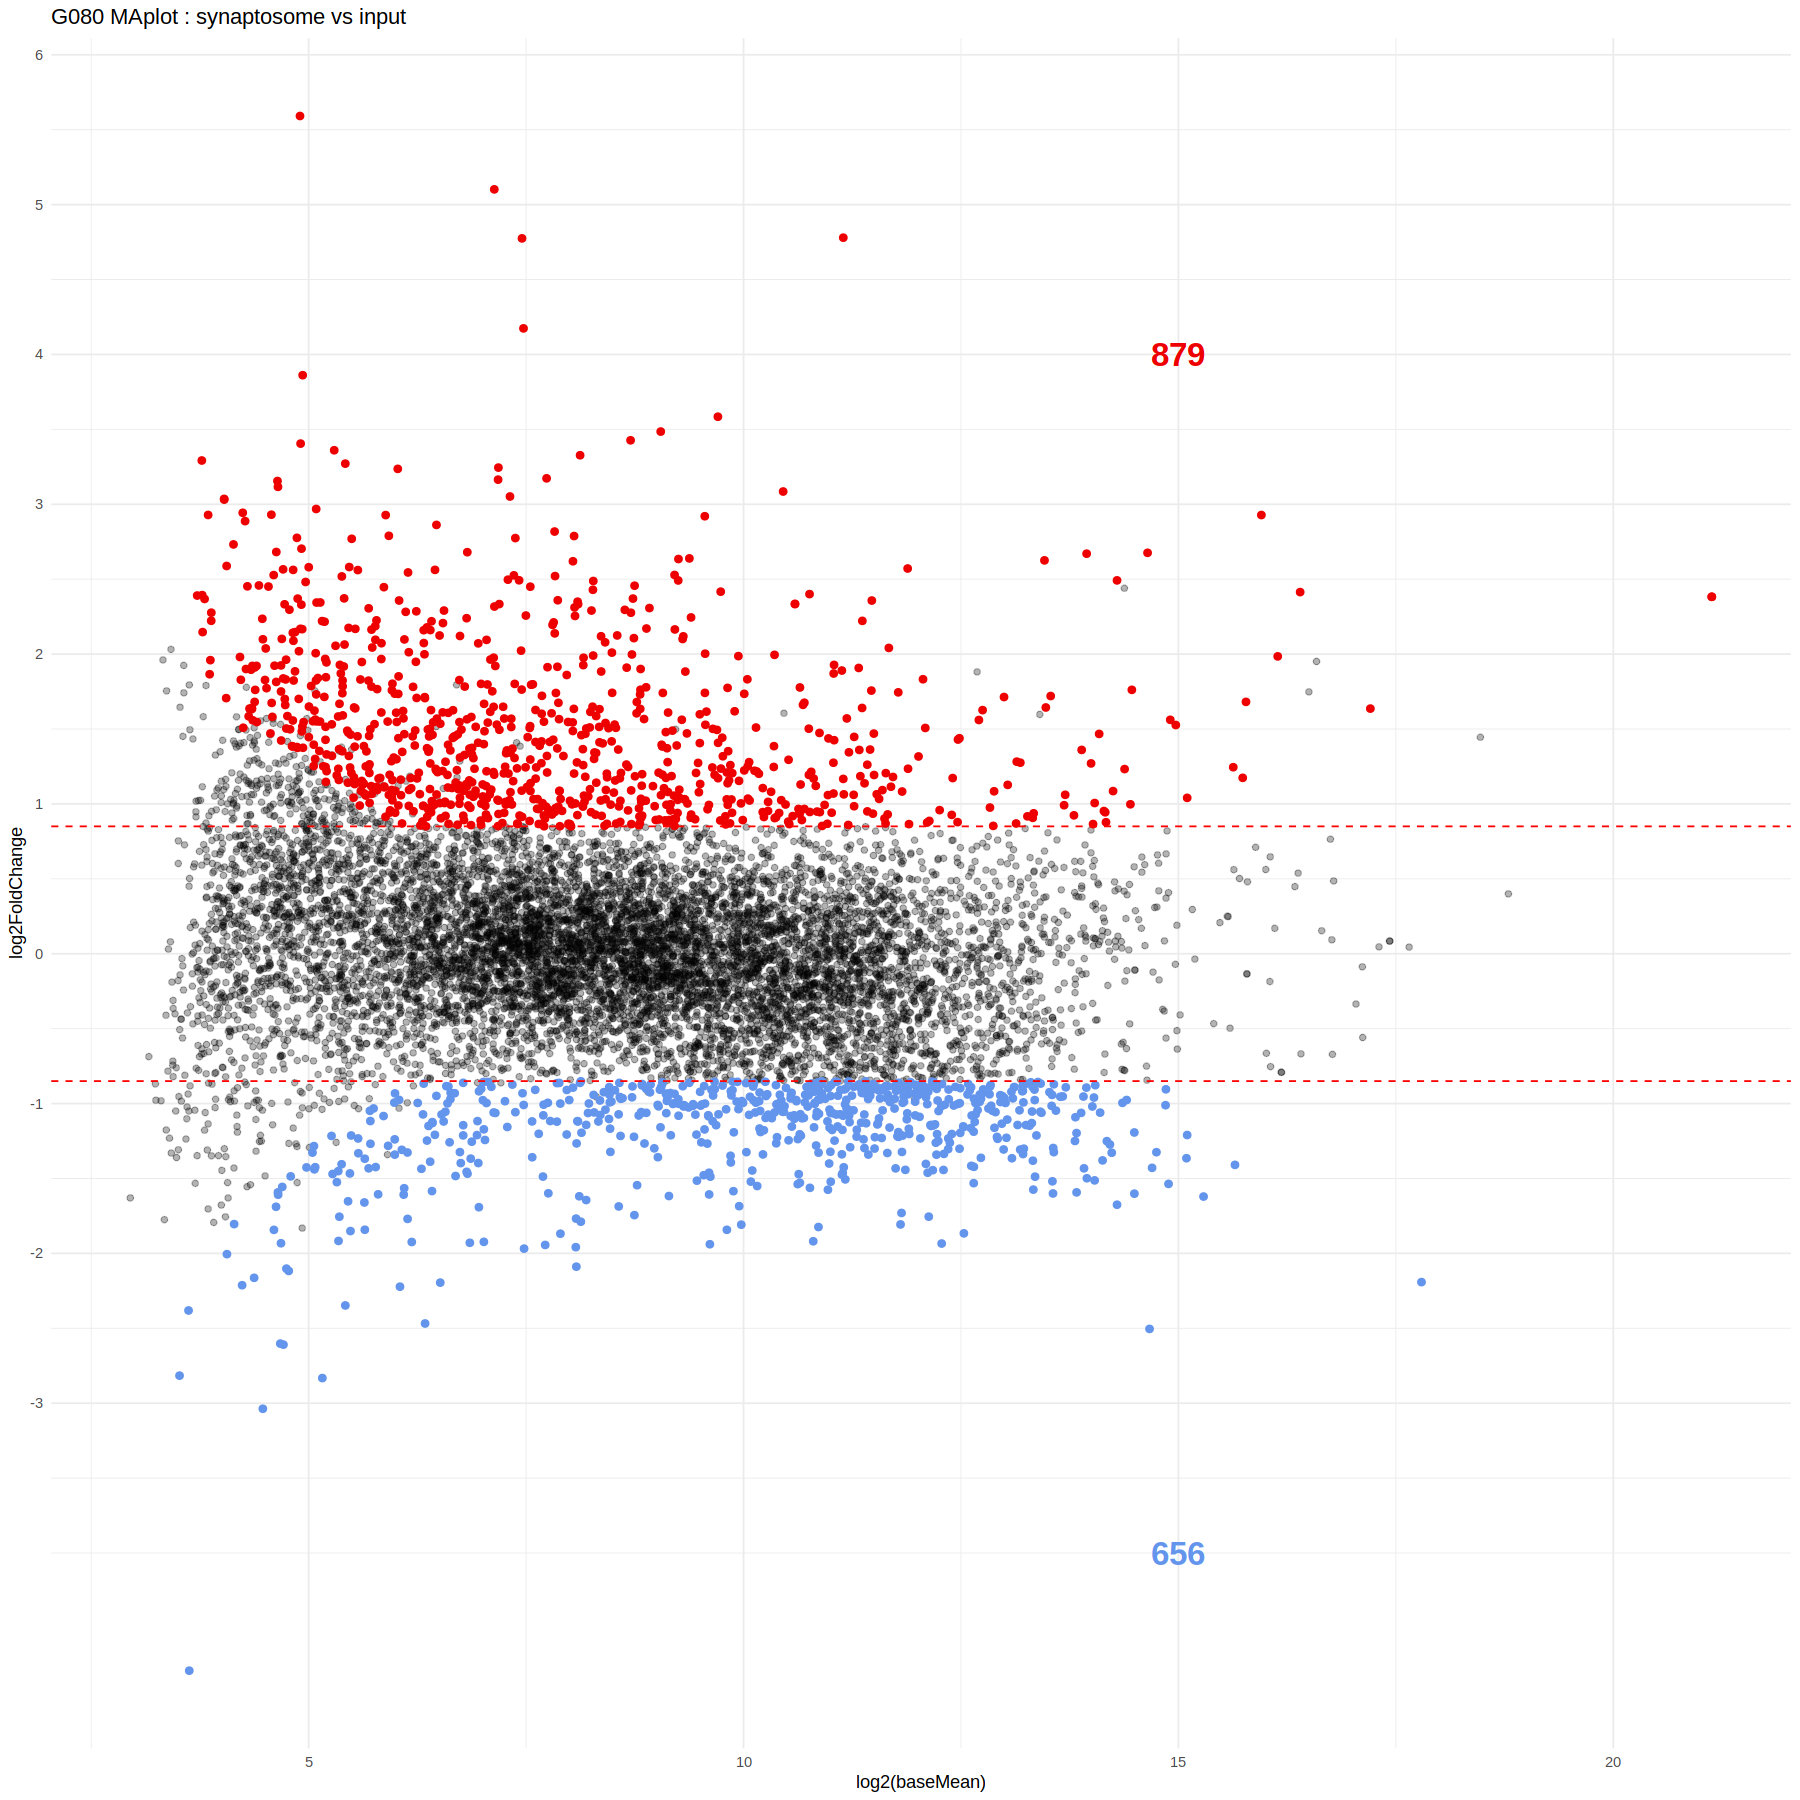

In [28]:
options(repr.plot.width=15, repr.plot.height=15)

res_up <- results.g080 %>% 
             filter(log2FoldChange >= 0.85 & padj<0.05)

res_down <- results.g080 %>% 
             filter(log2FoldChange <= -0.85 & padj<0.05)

maplot_nolabel1 <- ggplot(results.g080, aes(log2(baseMean), log2FoldChange)) + 
        geom_point(alpha=0.3) +
        geom_point(data=res_up,
            aes(log2(baseMean), log2FoldChange),color="red2", cex=1.8)+
        geom_point(data=res_down,
            aes(log2(baseMean), log2FoldChange),color="cornflowerblue", cex=1.8) + 
        geom_hline(yintercept=0.85, linetype="dashed", color = "red")+ 
        geom_hline(yintercept=-0.85, linetype="dashed", color = "red")+
        ggtitle("G080 MAplot : synaptosome vs input")+
        theme(plot.title = element_text(color = "black", 
                                    size = 20,
                                    face = 2,
                                     hjust=0.5))+ 
        annotate("text", x = c(15,15), y = c(4,-4), 
        label = c(dim(res_up)[1], dim(res_down)[1]) , color=c("red2","cornflowerblue"), 
        size=7 , angle=0, fontface="bold") + theme_minimal()+
  scale_y_continuous(breaks = c(-3, -2, -1, 0, 1, 2, 3, 4, 5, 6))

maplot_nolabel1

## -- DPLD --

### plot 2 : VolcanoPlot

In [29]:
#let's display and annotate genes that have significant LFC greater or equal to +0.85 / lower or equal to -0.85.
VolPlot.dpld = results.dpld %>% 
  mutate(
    Expression = case_when(log2FoldChange >= 0.85 & padj < 0.05 ~ "Up-regulated in synaptosome",
                           log2FoldChange <= -0.85 & padj < 0.05 ~ "Up-regulated in other fractions",
                           TRUE ~ "Unchanged")
    )


In [30]:
# adding ENSEMBL gene names to the table
mapping_geneNames <-  getBM(attributes=c("ensembl_gene_id","external_gene_name", "transcript_biotype"), mart=mart, values=VolPlot.dpld, uniqueRows=TRUE, bmHeader = T)
VolPlot.dpld = merge(VolPlot.dpld,mapping_geneNames, by.x='row.names', by.y='Gene stable ID', all.x=TRUE, all.y=FALSE)
rownames(VolPlot.dpld)=VolPlot.dpld$Row.names
VolPlot.dpld$Row.names=NULL
head(VolPlot.dpld)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Expression,Gene name,Transcript type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
FBgn0000003,4.896346e+06,2.45991978,0.07921233,31.0547596,9.839606e-212,2.929743e-208,Up-regulated in synaptosome,7SLRNA:CR32864,ncRNA
FBgn0000008,1.710446e+03,0.05628634,0.11689054,0.4815303,6.301396e-01,7.070149e-01,Unchanged,a,protein_coding
FBgn0000014,4.704513e+01,0.25501831,0.38652200,0.6597770,5.093970e-01,5.986106e-01,Unchanged,abd-A,protein_coding
FBgn0000015,5.407070e+01,-0.84775298,0.37905045,-2.2365175,2.531789e-02,4.526889e-02,Unchanged,Abd-B,protein_coding
FBgn0000017,8.993577e+03,0.03419349,0.08711228,0.3925220,6.946726e-01,7.636653e-01,Unchanged,Abl,protein_coding
FBgn0000018,1.988443e+02,-0.44843472,0.20481034,-2.1895121,2.855964e-02,5.023649e-02,Unchanged,abo,protein_coding


In [31]:
# genes with significant LFC >= 0.85 are enriched in fractions enriched in synaptosomes.
# genes with significalt LFC <= -0.85 are enriched in the input franctions
top <- 20
top_genes <- bind_rows(
  VolPlot.dpld %>% 
    filter(Expression == 'Up-regulated in synaptosome') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  VolPlot.dpld %>% 
    filter(Expression == 'Up-regulated in other fractions') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)

Warning message in geom_label_repel(data = top_genes, mapping = aes(log2FoldChange, :
“Ignoring unknown parameters: `face`”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


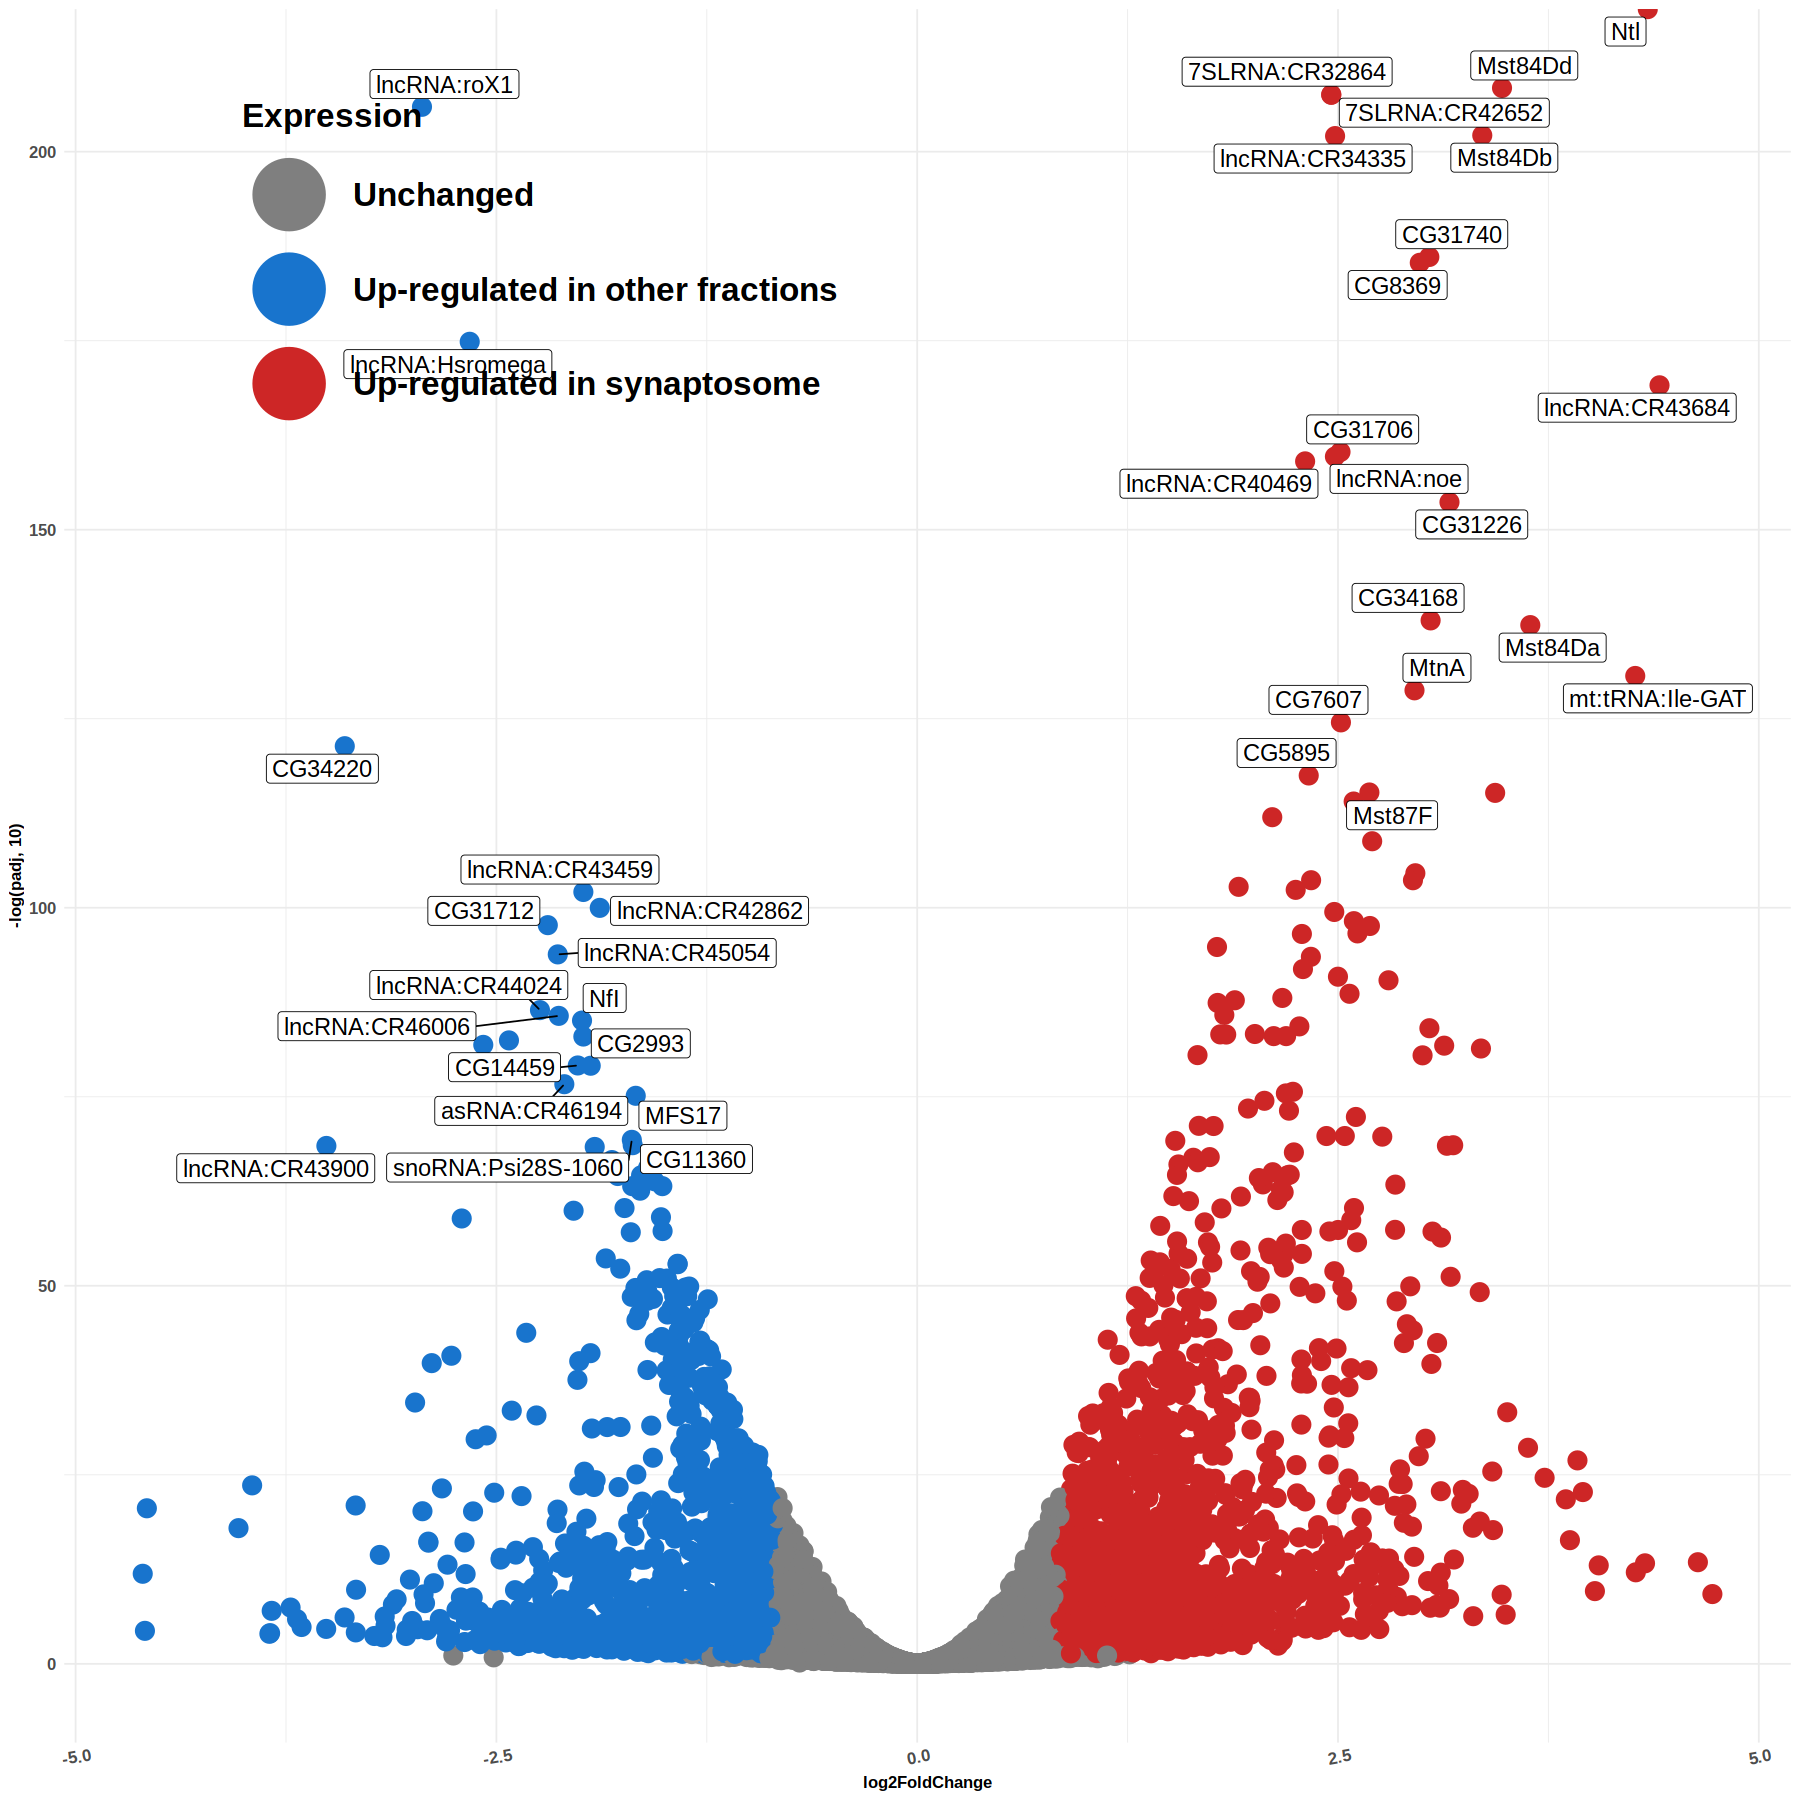

In [32]:
options(repr.plot.width=15, repr.plot.height=15)
VolcanoPlot.dpld=ggplot(VolPlot.dpld, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 5) +
  scale_color_manual(values = c("gray50","dodgerblue3",  "firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=20)))+
  geom_label_repel(data = top_genes,
                   mapping = aes(log2FoldChange, -log(padj,10), label = `Gene name`),
                   size = 5, face='bold')+
  theme_minimal()+
  theme(axis.text.x = element_text(angle=10, size = 10, face='bold'),
          axis.text.y = element_text(size = 10, face='bold'),
        axis.title = element_text(size =10, face='bold'),
         plot.title= element_text(hjust = 0.5, size = 20, face='bold'),
        legend.text = element_text(size = 20, face='bold'),
        legend.title = element_text(size = 20, face='bold'),
        legend.key.size = unit(3,"line"),
    legend.position = c(.1, .95),
    legend.justification = c("left", "top"),
    legend.box.just = "left",legend.margin = margin(3, 3, 3, 3))
VolcanoPlot.dpld

### plot 3 : MAplot

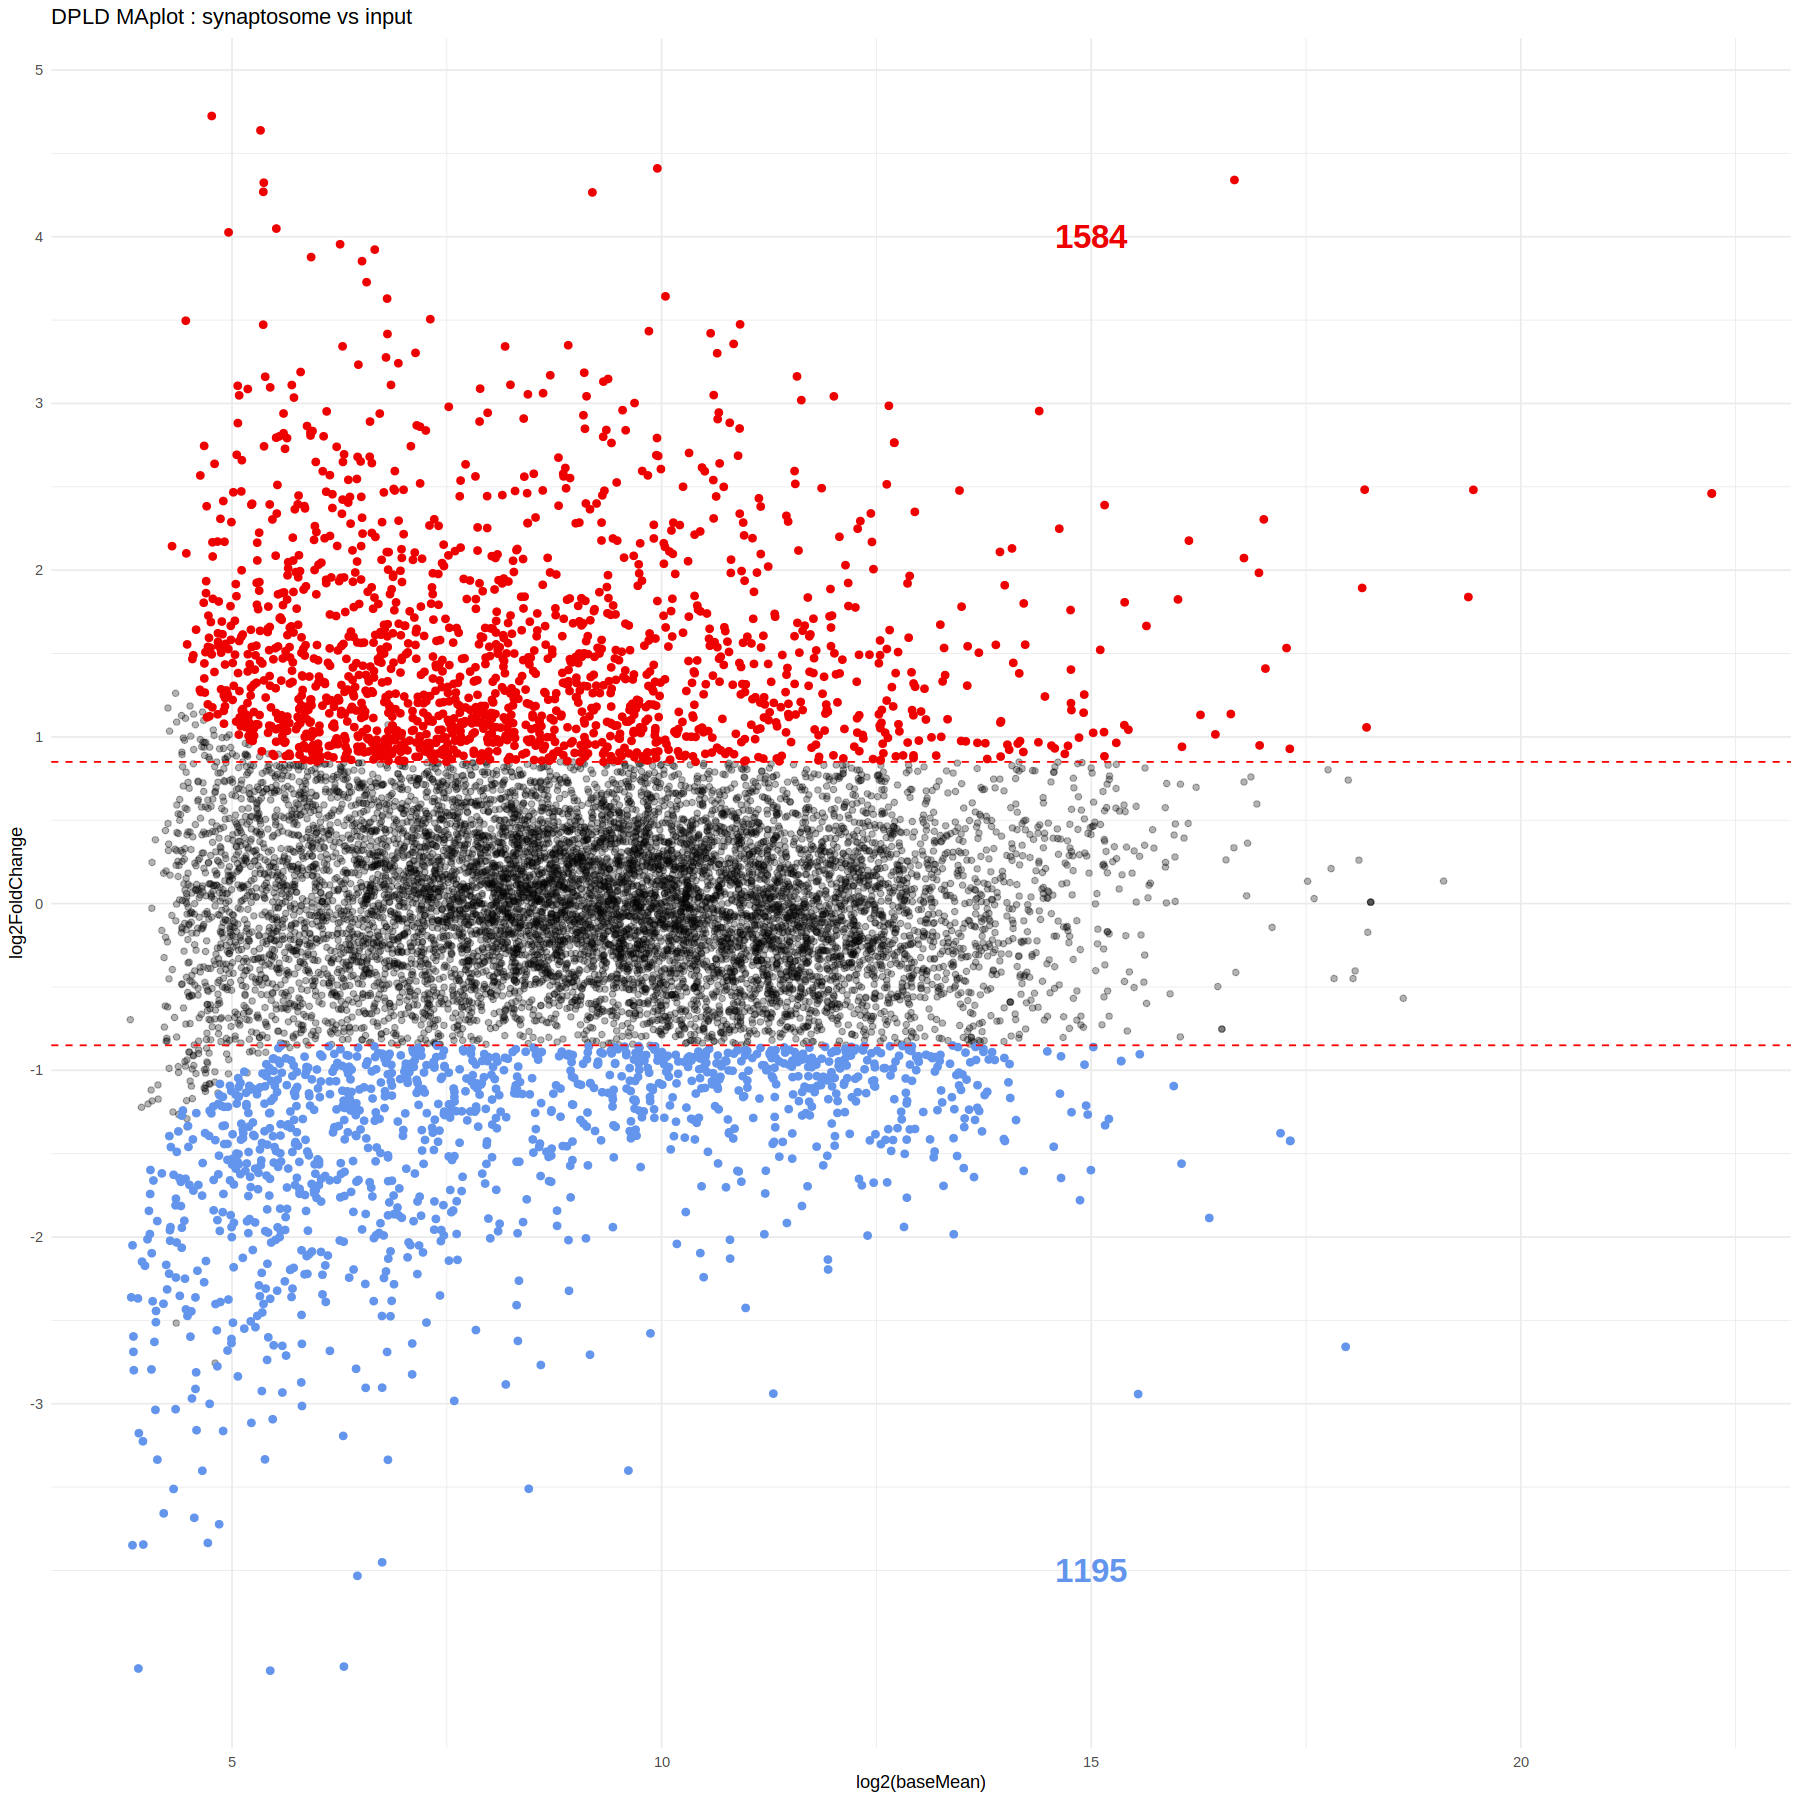

In [33]:
options(repr.plot.width=15, repr.plot.height=15)

res_up <- results.dpld %>% 
             filter(log2FoldChange >= 0.85 & padj<0.05)

res_down <- results.dpld %>% 
             filter(log2FoldChange <= -0.85 & padj<0.05)

maplot.dPLD <- ggplot(results.dpld, aes(log2(baseMean), log2FoldChange)) + 
        geom_point(alpha=0.3) +
        geom_point(data=res_up,
            aes(log2(baseMean), log2FoldChange),color="red2", cex=1.8)+
        geom_point(data=res_down,
            aes(log2(baseMean), log2FoldChange),color="cornflowerblue", cex=1.8) + 
        geom_hline(yintercept=0.85, linetype="dashed", color = "red")+ 
        geom_hline(yintercept=-0.85, linetype="dashed", color = "red")+
        ggtitle("DPLD MAplot : synaptosome vs input")+
        theme(plot.title = element_text(color = "black", 
                                    size = 20,
                                    face = 2,
                                     hjust=0.5))+ 
        annotate("text", x = c(15,15), y = c(4,-4), 
        label = c(dim(res_up)[1], dim(res_down)[1]) , color=c("red2","cornflowerblue"), 
        size=7 , angle=0, fontface="bold") + theme_minimal()+
  scale_y_continuous(breaks = c(-3, -2, -1, 0, 1, 2, 3, 4, 5, 6))

maplot.dPLD